## **<p align="center">**`🔍 EDA (Exploratory Data Analysis) 🔍`**</p>**

En este notebook comprenderemos la estructura y caracteristicas de los datos extraidos y tratados en el proceso de ETL. Se identificaran patrones, anomalias y se formularan hipotesis de investigacion. 
Utilizaremos herramientas graficas para el modelado del sistema de recomendacion en base a **que tan similar es un ítem al resto**; para ello aplicaremos la similitud del coseno


* importo librerias necesarias:

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import ast
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

* leo archivos necesarios para el proceso

In [56]:
df_games = pd.read_csv(r'DataApi/df_games.csv')
df_reviews = pd.read_csv(r'DataApi/df_reviews.csv')
df_items1 = pd.read_parquet(r'DataApi/items_new.parquet')
df_items2 = pd.read_parquet(r'DataApi/items_reducido.parquet')

elimino una columna que me quedo pendiente de eliminar en el proceso de etl y que no es necesaria tampoco para los analisis.

In [57]:
df_games.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
df_games.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'specs', 'price', 'early_access', 'id',
       'developer'],
      dtype='object')

In [136]:
df_reviews.drop(columns = ['Unnamed: 0'], inplace = True)

In [137]:
df_reviews.columns

Index(['funny', 'posted', 'item_id', 'recommend', 'user_id',
       'sentiment_analysis'],
      dtype='object')

In [138]:
df_items2.columns

Index(['item_id', 'playtime_forever', 'user_id'], dtype='object')

## *Analisis generos y etiquetas*

* echo un vistazo a los datos basicos:

In [139]:
df_games.describe()

,early_access,id
count,32135.000000,3.213300e+04
mean,0.060588,4.517574e+05
std,0.238577,1.827140e+05
min,0.000000,1.000000e+01
25%,0.000000,3.292800e+05
50%,0.000000,4.520600e+05
75%,0.000000,5.934000e+05
max,1.000000,2.028850e+06


In [140]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24064 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.2+ MB


In [141]:
df_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140.0,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,Secret Level SRL


en este caso las features que nos interesa estudiar son los titulos de los juegos, los generos, los id y tags

* elimino nulos de la columna id

In [142]:
df_games.dropna(subset=['id'], inplace=True)
df_games.reset_index(drop=True,inplace=True)

* cambio el tipo de dato a fines practicos

In [143]:
df_games.id = df_games.id.astype(int)

In [144]:
print(type(df_games.tags[0]))
print(type(df_games.genres[0]))

<class 'str'>
<class 'str'>


* creo un nuevo df para analizar dos variables de interes

In [145]:
games = df_games[['tags', 'genres']]
games

,tags,genres
0,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...","['Action', 'Casual', 'Indie', 'Simulation', 'S..."
1,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Free to Play', 'Indie', 'RPG', 'Strategy']"
2,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Casual', 'Free to Play', 'Indie', 'Simulatio..."
3,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']"
4,"['Action', 'Indie', 'Casual', 'Sports']",NaN
...,...,...
32128,"['Strategy', 'Indie', 'Casual', 'Simulation']","['Casual', 'Indie', 'Simulation', 'Strategy']"
32129,"['Strategy', 'Indie', 'Casual']","['Casual', 'Indie', 'Strategy']"
32130,"['Indie', 'Simulation', 'Racing']","['Indie', 'Racing', 'Simulation']"
32131,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","['Casual', 'Indie']"


In [146]:
games.dropna(inplace = True)

C:\Users\usuario\AppData\Local\Temp\ipykernel_6852\3138494946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games.dropna(inplace = True)


corrijo el tipo de dato de listas a str usando ast

In [147]:
games['genres'] = games['genres'].apply(lambda x: ast.literal_eval(x))

C:\Users\usuario\AppData\Local\Temp\ipykernel_6852\3384779288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['genres'] = games['genres'].apply(lambda x: ast.literal_eval(x))


* analizo la distribucion de la variable genres

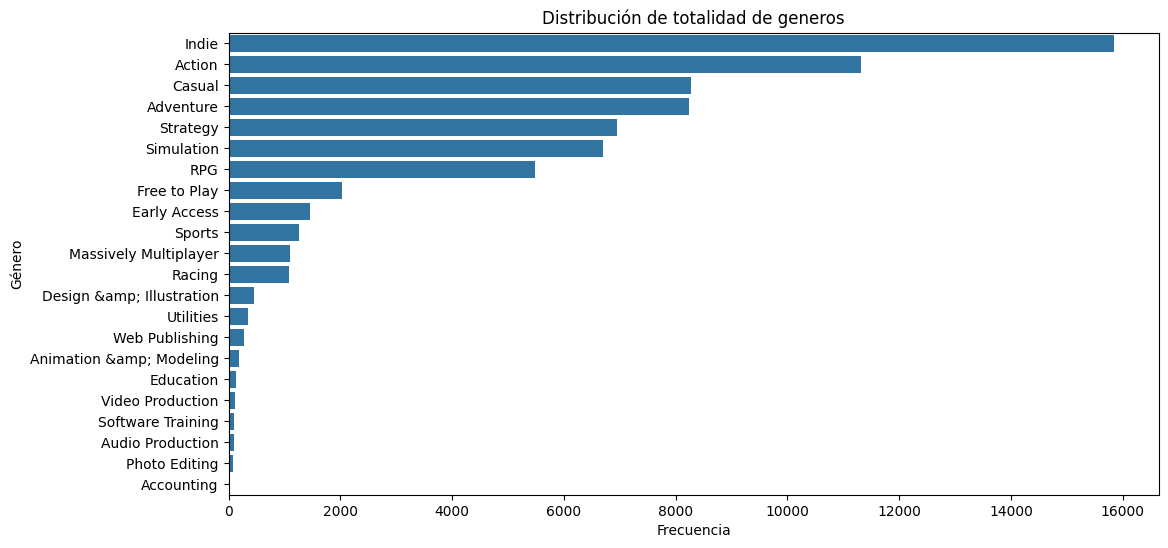

In [148]:
genre_counts = games['genres'].explode().value_counts()

# gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h')
plt.xlabel('Frecuencia')
plt.ylabel('Género')
plt.title('Distribución de totalidad de generos')
plt.show()

corrijo el tipo de dato de tags

In [149]:
games['tags'] = games['tags'].apply(lambda x: ast.literal_eval(x))

C:\Users\usuario\AppData\Local\Temp\ipykernel_6852\622821304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['tags'] = games['tags'].apply(lambda x: ast.literal_eval(x))


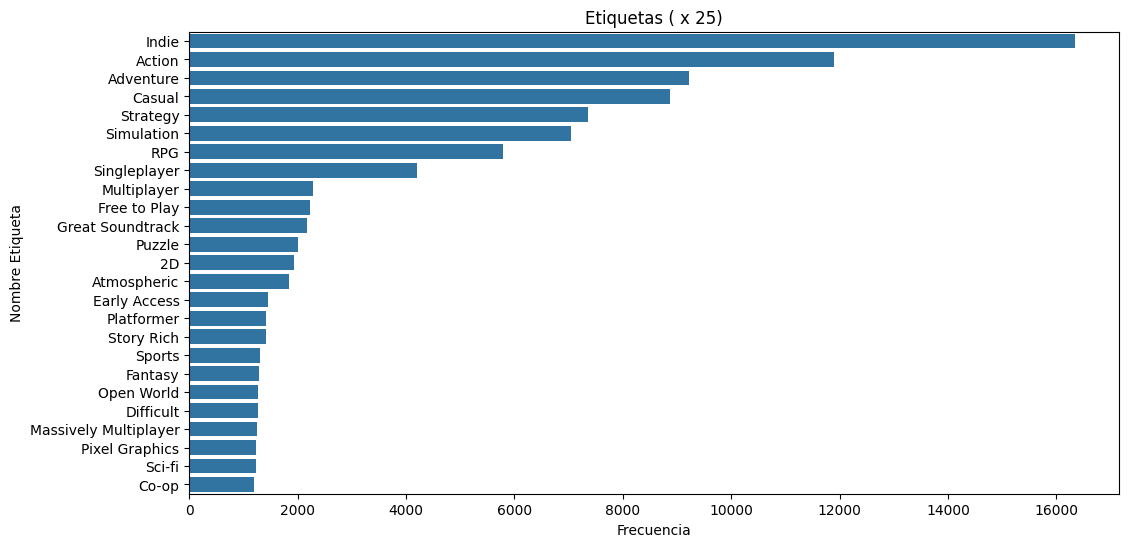

In [150]:
tag_counts = games['tags'].explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.values[:25], y=tag_counts.index[:25], orient='h')
plt.xlabel('Frecuencia')
plt.ylabel('Nombre Etiqueta')
plt.title('Etiquetas ( x 25)')
plt.show()

In [151]:
# Calcular la frecuencia de cada género en 'genres'
genre_counts = games['genres'].explode().value_counts()

# Calcular la frecuencia de cada etiqueta en 'tags'
tag_counts = games['tags'].explode().value_counts()

conozco la cantidad total de categorias que tiene cada una de las variables

In [152]:
genre_counts.sum()

71506

In [153]:
tag_counts.sum()

155271

considerando que el número de categorias en las etiquetas (tags) es significativamente mayor que en los géneros (genres), puede resultar difícil visualizar la diferencia, por lo cual se graficara un top 30 en tags comparando con genres

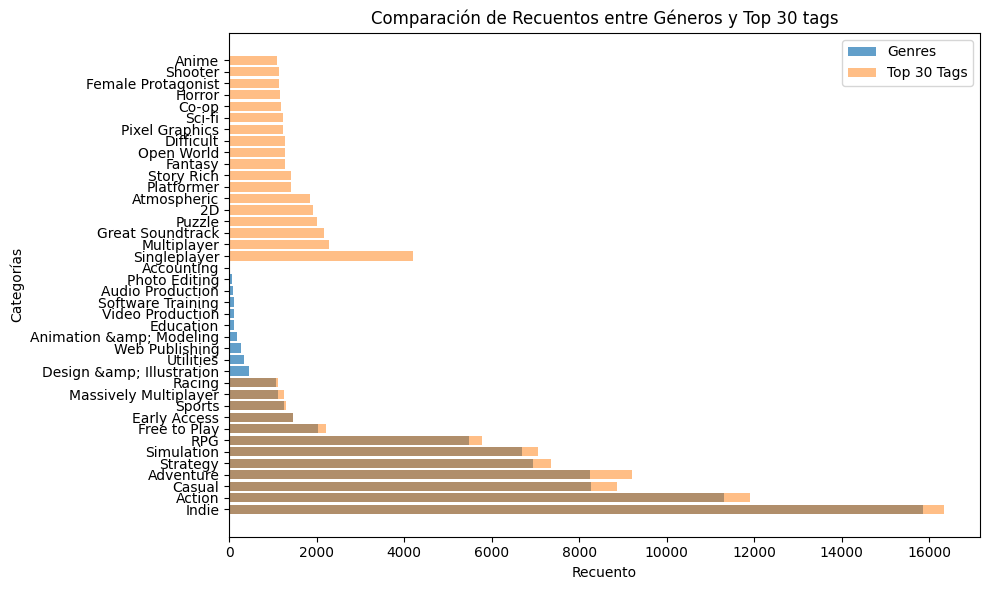

In [154]:
tag_counts_top30 = games['tags'].explode().value_counts().head(30)

plt.figure(figsize=(10, 6))

# Trazar los recuentos de 'genres' en un gráfico de barras
plt.barh(genre_counts.index, genre_counts.values, alpha=0.7, label='Genres')

# Trazar los recuentos de las 10 primeras etiquetas en un gráfico de barras agrupadas
plt.barh(tag_counts_top30.index, tag_counts_top30.values, alpha=0.5, label='Top 30 Tags')

# Añadir etiquetas, título y leyenda
plt.xlabel('Recuento')
plt.ylabel('Categorías')
plt.title('Comparación de Recuentos entre Géneros y Top 30 tags')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

podemos visualizar que la variable tags cuenta con mayores cantidad de datos a comparacion de gnres lo cual puede proporcionar una mayor informacion en términos de descripción de los juegos para los usuarios y realizar una calsificacion mas generalizada para los jugadores ayudando a entender la experiencia de los otros

## *Analisis sobre los comentarios:*

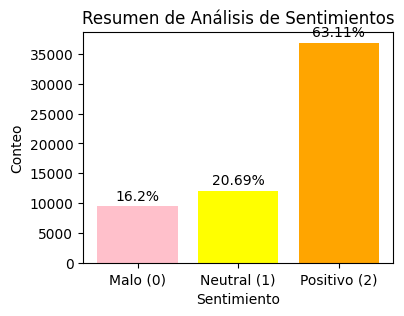

In [168]:
sentiment_summary = df_reviews['sentiment_analysis'].value_counts()
percentage_summary = (df_reviews['sentiment_analysis'].value_counts(normalize=True) * 100).round(2)

# Crear un nuevo DataFrame con el resumen
resumen_sentimientos = pd.DataFrame({
    'Conteo': sentiment_summary,
    'Porcentaje': percentage_summary.astype(str) + '%'
})

# Ordenar el DataFrame por el conteo de mayor a menor
resumen_sentimientos = resumen_sentimientos.sort_index()

# Visualizar el resumen
fig, ax = plt.subplots(figsize=(4, 3))

# Crear barras para el conteo
ax.bar(resumen_sentimientos.index, resumen_sentimientos['Conteo'], color=['pink', 'yellow', 'orange'])

# Mostrar porcentajes encima de las barras
for i, v in enumerate(resumen_sentimientos['Porcentaje']):
    ax.text(i, resumen_sentimientos['Conteo'][i] + 500, f"{v}", ha='center', va='bottom')

# Configurar el gráfico
ax.set_title('Resumen de Análisis de Sentimientos')
ax.set_xlabel('Sentimiento')
ax.set_ylabel('Conteo')
ax.set_xticks(resumen_sentimientos.index)
ax.set_xticklabels(['Malo (0)', 'Neutral (1)', 'Positivo (2)'])

# Mostrar el conteo de reviews en blanco
conteo_reviews_en_blanco = (df_reviews['sentiment_analysis'].isnull()).sum()
porcentaje_reviews_en_blanco = (conteo_reviews_en_blanco / len(df_reviews) * 100).round(2)


plt.show()

* la gran mayoria de las reseñas son positivas considerando un 63.11% del total de reseñas
* por otro lado, las reseñas clasificadas como neutrales representan un 20.69% del total lo que puede representar que de los usuarios, el 20% aproximadamente no tiene una opinon sesgada
* y por ultimo podemos observar que las reseñas con categoria malo, son de un 16.2%, porcentaje minoritario en relacion al total pero no menos importante. 

en conclusion podemos inferir que la plataforma steams tiene buena calificacion de parte de los usuarios